In [215]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [216]:
img = cv2.imread('./test_image/test8.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


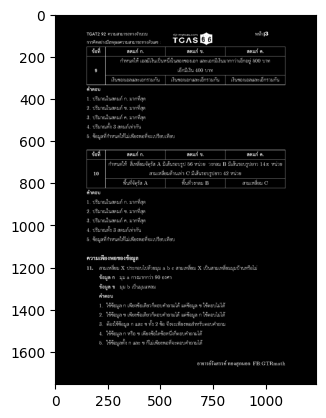

In [217]:
def thresholding(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    print(img_gray)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img)

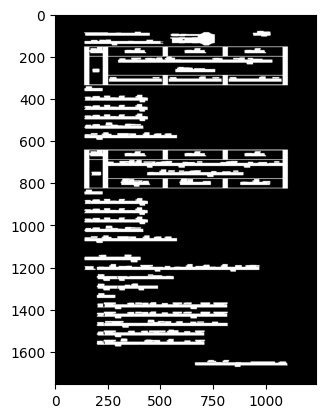

In [218]:
kernel = np.ones((3, 25), np.uint8)

#vertical lines kernel เพื่อเพิ่มขนาดของเส้นตามแนวตั้ง เพราะเราไม่รู้ว่ารูปที่ input เข้ามาจะเข้มแค่ไหน โดยใช้ kernel ขนาด 3x25 และใช้คำสั่ง dilate ในการทำการขยายขนาดของเส้น 1 ครั้ง โดยใช้ iterations=1
dilated = cv2.dilate(thresh_img, kernel, iterations=1)
plt.imshow(dilated, cmap='gray')

In [219]:
#หาเส้นขอบ โดยใช้ cv2.RETR_EXTERNAL คือการหาเส้นขอบที่เป็นเส้นขอบภายนอกที่สุด และ cv2.CHAIN_APPROX_NONE คือการหาเส้นขอบที่ไม่มีการประมาณ
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#เรียงค่าตาม Y ตามลำดับน้อยไปมาก
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1])

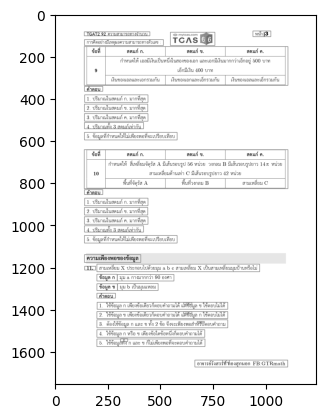

(36, 300, 3)


In [220]:
cropped_images = []

for ctr in sorted_contours_lines:
    x, y, w, h = cv2.boundingRect(ctr)

    #วาดสี่เหลี่ยมรอบตัวอักษร โดยใช้สี (40, 100, 250) และความหนา 2 pixel
    cv2.rectangle(img, (x, y), (x+w, y+h), (40, 100, 250), 2)

    #เอารูป Original มาตัด
    cropped_region = img[y:y+h, x:x+w] 
    cropped_images.append(cropped_region)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray') 
plt.show()
cv2.imshow(f'Cropped Image {1}', cv2.cvtColor(cropped_images[13], cv2.COLOR_BGR2GRAY))
print(cropped_images[13].shape)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[138 138 138 ... 138 138 138]
 [138 138 138 ... 138 138 138]
 [138 138 255 ... 255 255 138]
 ...
 [138 138 255 ... 255 255 138]
 [138 138 255 ... 255 255 138]
 [138 138 138 ... 138 138 138]]
[[138 138 138 ... 138 138 138]
 [138 138 138 ... 138 138 138]
 [138 138 255 ... 255 255 138]
 ...
 [138 138 255 ... 255 255 138]
 [138 138 255 ... 255 255 138]
 [138 138 138 ... 138 138 138]]
[[138 138 138 ... 138 138 138]
 [138 138 138 ... 138 138 138]
 [138 138 255 ... 255 255 138]
 ...
 [138 138 255 ... 255 255 138]
 [138 138 255 ... 255 255 138]
 [138 138 138 ... 138 138 138]]
[[138 138 138 ... 138 138 138]
 [138 138 138 ... 138 138 138]
 [138 138 255 ... 255 255 138]
 ...
 [138 138 255 ... 255 255 138]
 [138 138 255 ... 255 255 138]
 [138 138 138 ... 138 138 138]]
[[138 138 138 ... 138 138 138]
 [138 138 138 ... 138 138 138]
 [138 138 255 ... 255 255 138]
 ...
 [138 138 255 ... 255 255 138]
 [138 138 255 ... 255 255 138]
 [138 138 138 ... 138 138 138]]
[[138 138 138 ... 138 138 138]
 [138 138

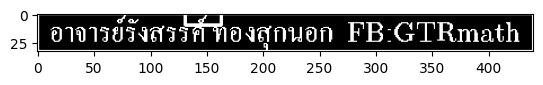

In [221]:
cropped_thresh = []
for i in cropped_images:
    cropped_thresh.append(thresholding(i))

cv2.imshow(f'Cropped Image {1}', cropped_thresh[2])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [242]:
def character_segmentation(img):
    
    #จำเป็นต้องใช้ library
    _, binary_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # ทำ CCA
    labels, num_labels = label_connected_components(binary_image)

    segmented_characters = []

    # วนลูปเพื่อตัดตัวอักษรออกมา
    for i in range(1, num_labels):
        # หาพิกเซลที่มีค่าไม่เป็นพื้นหลังของตัวอักษร
        indices = np.where(labels == i)
        min_row, min_col = np.min(indices, axis=1)
        max_row, max_col = np.max(indices, axis=1)
        
        # ตัดขนาดของตัวอักษรออกมา
        character_segment = img[min_row:max_row+1, min_col:max_col+1]
        segmented_characters.append(character_segment)
    
    return segmented_characters

def label_connected_components(binary_image):
    # สร้างเมทริกซ์เพื่อเก็บข้อมูล label ของแต่ละพิกเซล
    labels = np.zeros_like(binary_image)
    label_count = 1

    # วนลูปเพื่อประมวลผลแต่ละพิกเซลในภาพตามจำนวนความสูงของภาพ
    for i in range(binary_image.shape[0]):
        # วนลูปเพื่อประมวลผลแต่ละพิกเซลในภาพตามจำนวนความกว้างของภาพ
        for j in range(binary_image.shape[1]):
            # ถ้าพิกเซลปัจจุบันเป็นพิกเซลตัวอักษรและยังไม่ได้ถูก label 
            if binary_image[i, j] == 255 and labels[i, j] == 0:
                # เริ่มต้นการค้นหาตัวอักษรที่เชื่อมโยงกัน
                explore_connected_component(binary_image, labels, i, j, label_count)
                label_count += 1

    num_labels = label_count - 1
    return labels, num_labels

def explore_connected_component(binary_image, labels, row, col, label_count):
    # ตั้งค่า label ให้กับพิกเซลปัจจุบัน
    labels[row, col] = label_count
    
    # ตรวจสอบพิกเซลต่อไปที่เชื่อมโยงกับพิกเซลปัจจุบัน
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue  # ข้ามพิกเซลปัจจุบัน
            r = row + dr
            c = col + dc
            # ตรวจสอบว่าพิกเซลที่ติดกันเป็นตัวอักษรและยังไม่ได้ถูก label
            if 0 <= r < binary_image.shape[0] and 0 <= c < binary_image.shape[1] and \
               binary_image[r, c] == 255 and labels[r, c] == 0:
                explore_connected_component(binary_image, labels, r, c, label_count)


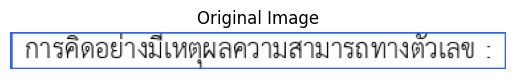

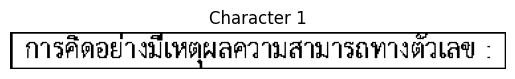

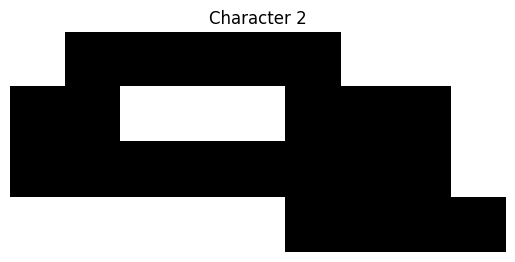

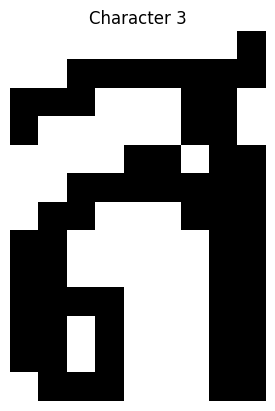

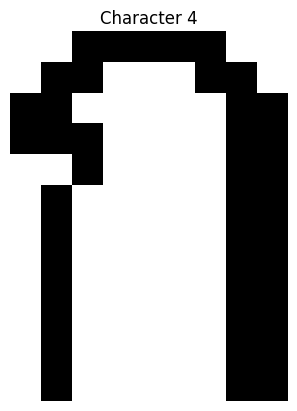

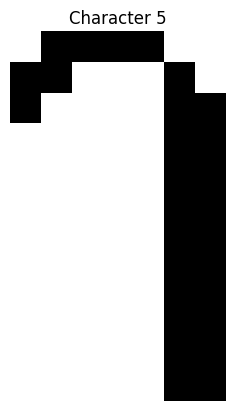

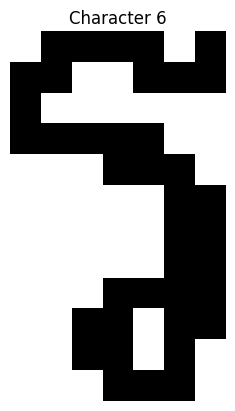

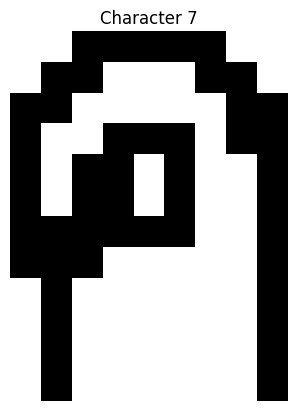

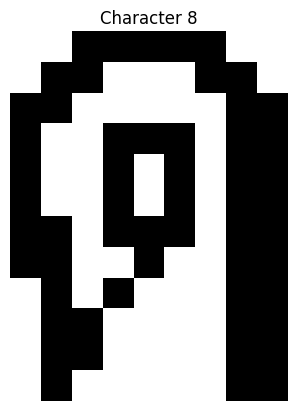

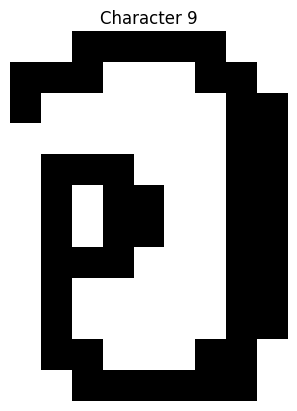

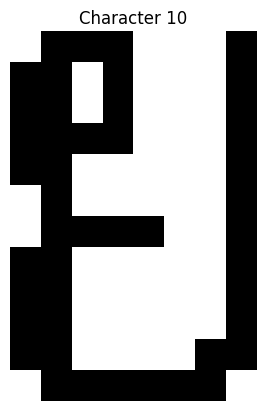

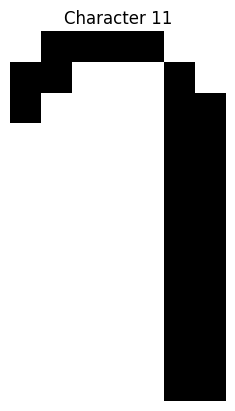

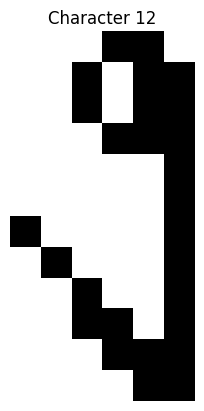

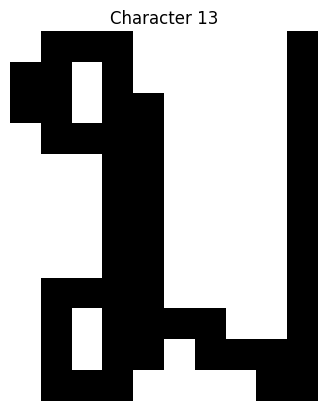

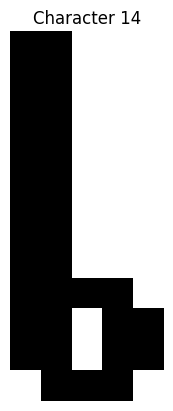

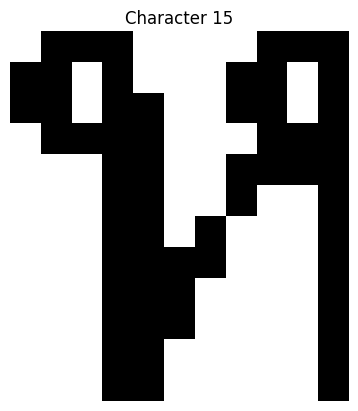

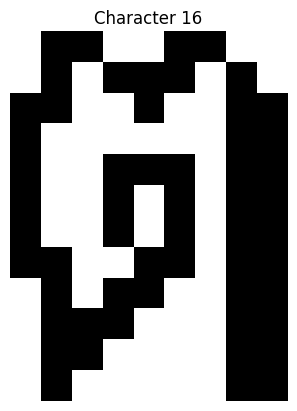

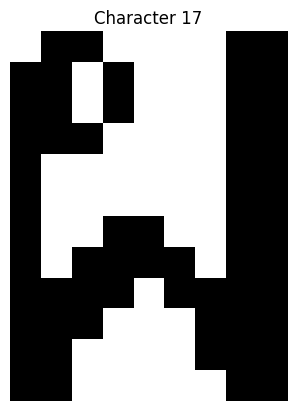

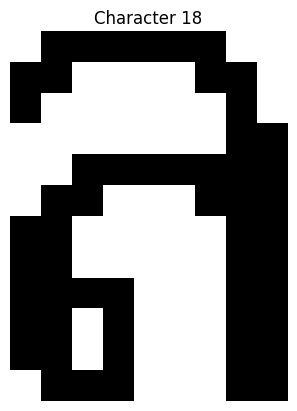

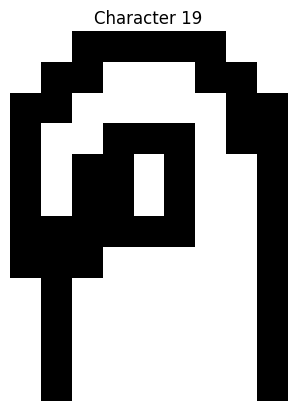

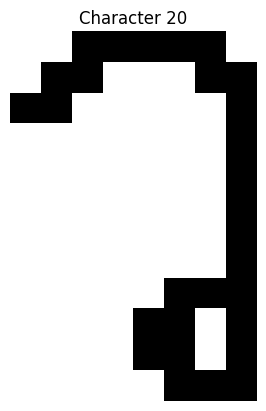

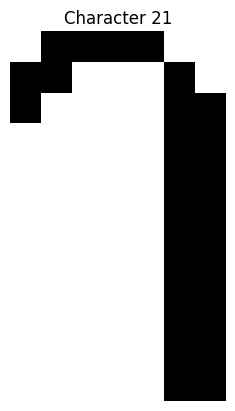

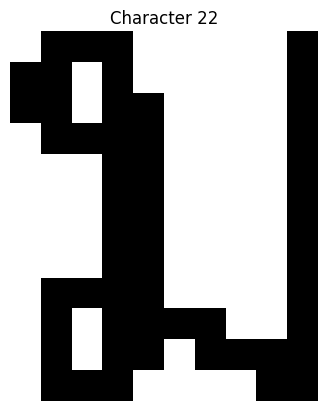

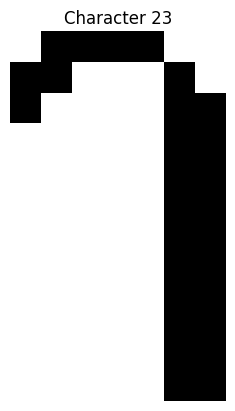

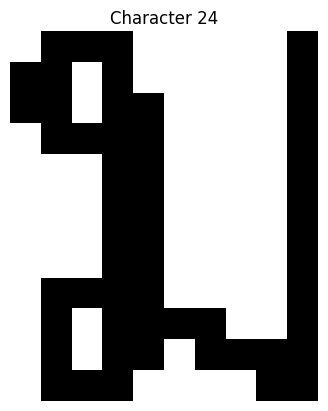

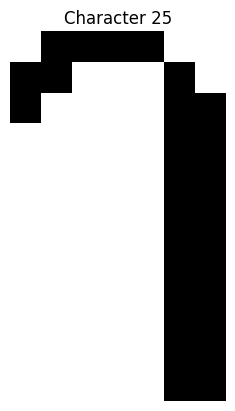

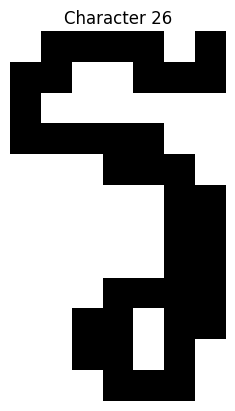

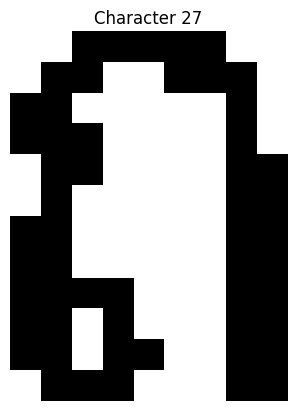

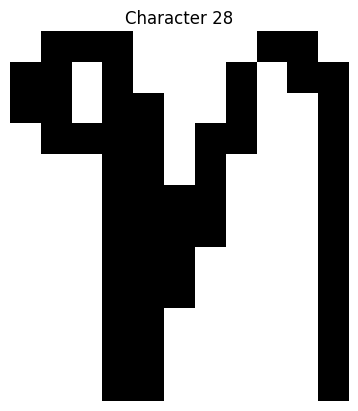

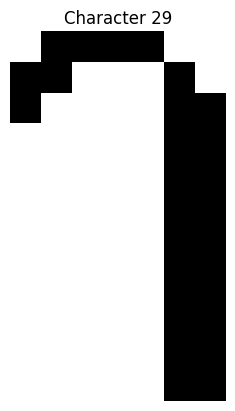

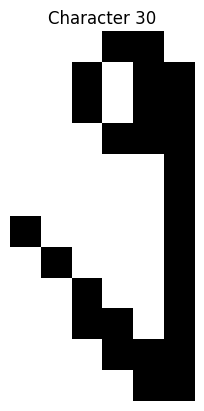

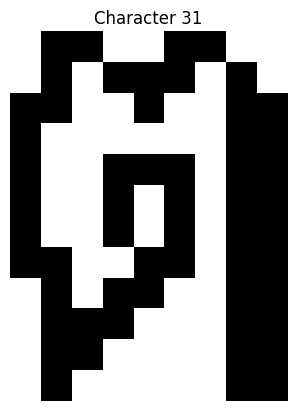

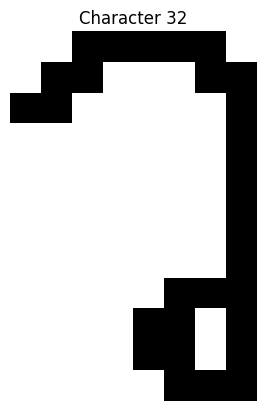

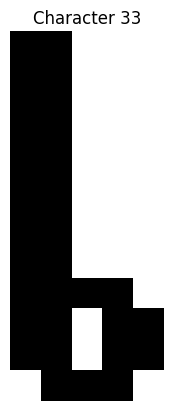

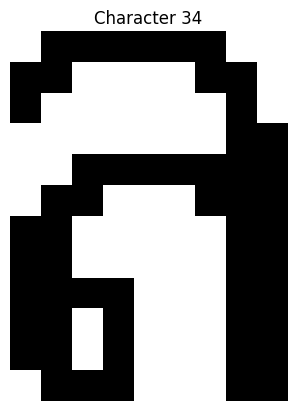

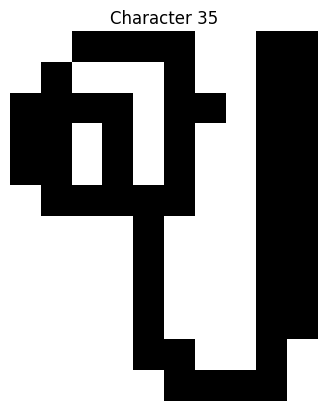

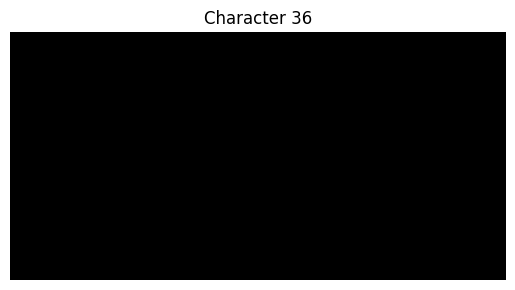

In [243]:
segmented_character = character_segmentation(cropped_thresh[3])
character = []
plt.figure()
plt.imshow(cropped_images[3], cmap='gray') 
plt.title('Original Image')
plt.axis('off')
plt.show()

#binarization ตัวอักษร เพื่อทำ datasets ในการ train model 
# การทำความสะอาดข้อมูล: การใช้ binarization บน datasets อาจช่วยในการทำความสะอาดข้อมูล 
#โดยการลดความซับซ้อนของข้อมูลหรือเน้นที่ส่วนที่สนใจของภาพ เช่น ส่วนของตัวอักษรในภาพเพื่อให้โมเดลสามารถเรียนรู้และทำนายได้ดีขึ้น

for i, char_segment in enumerate(segmented_character):
    character.append(cv2.bitwise_not(char_segment))
    plt.figure()
    plt.imshow(cv2.bitwise_not(char_segment), cmap='gray')
    plt.title(f'Character {i + 1}')
    plt.axis('off')
    plt.show()


In [241]:
from scipy.signal import find_peaks

def vowel_segmentation(word_segment):
    # Horizontal Projection
    horizontal_projection = np.sum(word_segment, axis=1)

    # Find peaks in the horizontal projection
    character_peaks, _ = find_peaks(horizontal_projection, height=3500)

    # Segment vowels
    segmented_vowels = []
    for i in range(len(character_peaks) - 1):
        top_row = character_peaks[i]
        bottom_row = character_peaks[i + 1]
        vowel_segment = word_segment[top_row:bottom_row, :]
        segmented_vowels.append(vowel_segment)

    # Add the last vowel segment
    last_vowel_segment = word_segment[character_peaks[-1]:, :]
    segmented_vowels.append(last_vowel_segment)

    return segmented_vowels

In [237]:
count = 0
for i, char_segment in enumerate(segmented_character):
    print(f"character {i} : {char_segment}")

# segmented_vowel = vowel_segmentation(segmented_character[1])

# for i, char_segment in enumerate(segmented_vowel):
#     print(char_segment)
#     cv2.imshow(f'Character {i + 1}', char_segment)


# cv2.waitKey(0)
# cv2.destroyAllWindows()

character 0 : [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255   0 ...   0   0 255]
 ...
 [255 255   0 ...   0   0 255]
 [255 255   0 ...   0   0 255]
 [255 255 255 ... 255 255 255]]
character 1 : [[  0 255 255 255 255 255   0   0   0]
 [255 255   0   0   0 255 255 255   0]
 [255 255 255 255 255 255 255 255   0]
 [  0   0   0   0   0 255 255 255 255]]
character 2 : [[  0   0   0   0   0   0   0   0 255]
 [  0   0 255 255 255 255 255 255 255]
 [255 255 255   0   0   0 255 255   0]
 [255   0   0   0   0   0 255 255   0]
 [  0   0   0   0 255 255   0 255 255]
 [  0   0 255 255 255 255 255 255 255]
 [  0 255 255   0   0   0 255 255 255]
 [255 255   0   0   0   0   0 255 255]
 [255 255   0   0   0   0   0 255 255]
 [255 255 255 255   0   0   0 255 255]
 [255 255   0 255   0   0   0 255 255]
 [255 255   0 255   0   0   0 255 255]
 [  0 255 255 255   0   0   0 255 255]]
character 3 : [[  0   0 255 255 255 255 255   0   0]
 [  0 255 255   0   0   0 255 255   0]
 [255 255

In [238]:
# vowel_characters = []
# for char_segment in segmented_character:
#     vowel_characters.append(vowel_segmentation(char_segment))

# for i, vowel_segment_list in enumerate(vowel_characters):
#     for j, vowel_segment in enumerate(vowel_segment_list):
#         cv2.imshow(f'Vowel {i + 1} - Segment {j + 1}', vowel_segment)
#         cv2.waitKey(0)

# cv2.destroyAllWindows()


In [227]:

# def vowel_segmentation(word_segment, character_threshold=3500, character_height=10, character_gap=5):
#     horizontal_projection = np.sum(word_segment, axis=1)
#     character_peaks, _ = find_peaks(horizontal_projection, height=character_threshold)

#     segmented_characters = []

#     for peak_row in character_peaks:
#         middle_row = peak_row
#         start_row = max(0, middle_row - character_height // 2 - character_gap)
#         end_row = min(word_segment.shape[0], middle_row + character_height // 2)
#         character_segment = word_segment[start_row:end_row, :]
#         segmented_characters.append(character_segment)

#     return segmented_characters


# def char_segmentation(image, character_threshold=3500, character_height=10, character_gap=5):
#     horizontal_projection = np.sum(image, axis=1)
#     character_peaks, _ = find_peaks(horizontal_projection, height=character_threshold)

#     segmented_characters = []

#     for i in range(len(character_peaks) - 1):
#         start_row = character_peaks[i]
#         end_row = character_peaks[i + 1]
#         character_segment = image[start_row:end_row, :]
#         segmented_characters.append(character_segment)
#     segmented_characters.append(image[character_peaks[-1]:, :])

#     return segmented_characters

In [228]:
# vo = characters_list[3]
# segmented_characters = char_segmentation(characters_list[3])

# for i, char_segment in enumerate(segmented_characters):
#     print(char_segment)
#     cv2.imshow(f'Character {i + 1}', char_segment)


# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [229]:
# segmented_vowel = vowel_segmentation(vo)

# for i, char_segment in enumerate(segmented_vowel):
#     cv2.imshow(f'Character {i + 1}', char_segment)


# cv2.waitKey(0)
# cv2.destroyAllWindows()